In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 12, 3),  # 28x28 output 26x26 RF : 3x3
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout2d(0.1),
           
            nn.Conv2d(12, 12, 3), # 26x26 output 24x24 RF : 5x5
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout2d(0.1),
           
            nn.Conv2d(12, 24, 3), # 24x24 output 22x22 RF : 7x7
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout2d(0.1),
        
        )

        self.trans1 = nn.Sequential(
            
            nn.Conv2d(24, 12, 1), # 24x24 output 22x22 RF : 7x7
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.AvgPool2d(2, 2),  # 22x22 output - 11x11 RF 14x14

        )

        self.conv2 =  nn.Sequential(

            nn.Conv2d(12, 16, 3), # 11x11 output - 9x9 RF 16x16
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),
            
            nn.Conv2d(16, 32, 3),  # 9x9 output - 7x7 RF 18x18
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),
            
        )

        self.trans2 = nn.Sequential(

            nn.Conv2d(32, 16, 1), # 9x9 output - 7x7 RF 18x18
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.AvgPool2d(2, stride=2, padding=0)
        )
        self.fc = nn.Linear(16*3*3,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return F.log_softmax(x,dim=1)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
         Dropout2d-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
         Dropout2d-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 24, 22, 22]           2,616
             ReLU-10           [-1, 24, 22, 22]               0
      BatchNorm2d-11           [-1, 24, 22, 22]              48
        Dropout2d-12           [-1, 24, 22, 22]               0
           Conv2d-13           [-1, 12, 22, 22]             300
             ReLU-14           [-1, 12,

In [4]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        #transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1), shear=0.08),                         
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [5]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) 
        train_loss += loss.item()       
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return train_loss, 100.*correct/len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100.*correct/len(test_loader.dataset)

In [6]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_loss_list = []
test_loss_list = []
train_accuracy_list=[]
test_accuracy_list=[]

for epoch in range(1, 20):
    print(f"Epoch {epoch}")
    if(epoch==10):
      optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    train_loss,train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss,test_acc = test(model, device, test_loader)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    train_accuracy_list.append(train_acc)
    test_accuracy_list.append(test_acc)



  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1


loss=0.05895450338721275 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 38.44it/s]


Train set: Average loss: 0.0020, Accuracy: 55632/60000 (92.72%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9844/10000 (98.44%)

Epoch 2


loss=0.19589729607105255 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.76it/s]


Train set: Average loss: 0.0006, Accuracy: 58634/60000 (97.72%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9884/10000 (98.84%)

Epoch 3


loss=0.05269436538219452 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.42it/s]


Train set: Average loss: 0.0004, Accuracy: 58955/60000 (98.26%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9894/10000 (98.94%)

Epoch 4


loss=0.05412048473954201 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.38it/s]


Train set: Average loss: 0.0004, Accuracy: 59109/60000 (98.52%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9913/10000 (99.13%)

Epoch 5


loss=0.017384842038154602 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.55it/s]


Train set: Average loss: 0.0003, Accuracy: 59204/60000 (98.67%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)

Epoch 6


loss=0.020023087039589882 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.37it/s]


Train set: Average loss: 0.0003, Accuracy: 59249/60000 (98.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

Epoch 7


loss=0.06728097051382065 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.54it/s]


Train set: Average loss: 0.0003, Accuracy: 59252/60000 (98.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9923/10000 (99.23%)

Epoch 8


loss=0.003209652379155159 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.84it/s]


Train set: Average loss: 0.0003, Accuracy: 59322/60000 (98.87%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9942/10000 (99.42%)

Epoch 9


loss=0.030697999522089958 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.24it/s]


Train set: Average loss: 0.0003, Accuracy: 59380/60000 (98.97%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)

Epoch 10


loss=0.014375305734574795 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.42it/s]


Train set: Average loss: 0.0002, Accuracy: 59474/60000 (99.12%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)

Epoch 11


loss=0.01940385065972805 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 38.29it/s]


Train set: Average loss: 0.0002, Accuracy: 59506/60000 (99.18%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)

Epoch 12


loss=0.023499831557273865 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 38.02it/s]


Train set: Average loss: 0.0002, Accuracy: 59506/60000 (99.18%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9945/10000 (99.45%)

Epoch 13


loss=0.034169454127550125 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.59it/s]


Train set: Average loss: 0.0002, Accuracy: 59509/60000 (99.18%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

Epoch 14


loss=0.01752757467329502 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.47it/s]


Train set: Average loss: 0.0002, Accuracy: 59502/60000 (99.17%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9940/10000 (99.40%)

Epoch 15


loss=0.015287205576896667 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.63it/s]


Train set: Average loss: 0.0002, Accuracy: 59519/60000 (99.20%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9941/10000 (99.41%)

Epoch 16


loss=0.022106455639004707 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.96it/s]


Train set: Average loss: 0.0002, Accuracy: 59506/60000 (99.18%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)

Epoch 17


loss=0.014538110233843327 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.62it/s]


Train set: Average loss: 0.0002, Accuracy: 59522/60000 (99.20%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)

Epoch 18


loss=0.016605885699391365 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.20it/s]


Train set: Average loss: 0.0002, Accuracy: 59512/60000 (99.19%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9946/10000 (99.46%)

Epoch 19


loss=0.027702972292900085 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.38it/s]


Train set: Average loss: 0.0002, Accuracy: 59534/60000 (99.22%)




Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)



Text(0.5, 1.0, 'Loss per epoch')

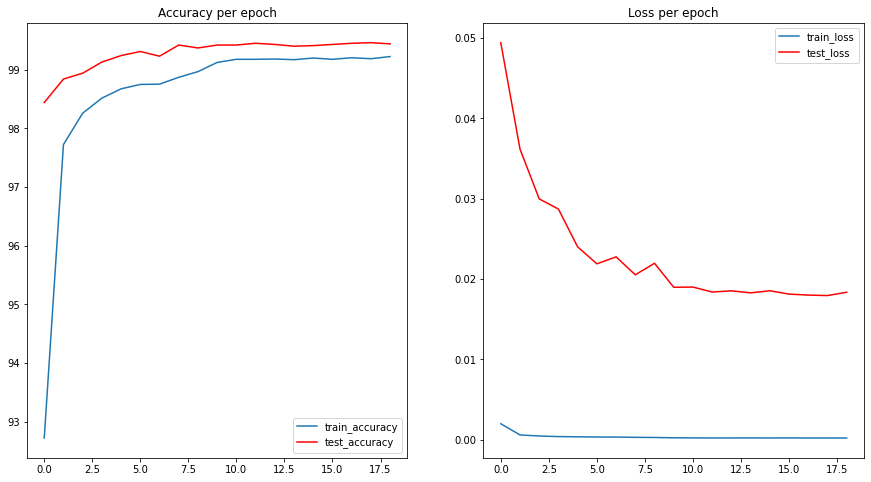

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

plt.subplot(1,2, 1)

plt.plot(np.array(train_accuracy_list))
plt.plot(np.array(test_accuracy_list), 'r')
plt.legend(["train_accuracy", "test_accuracy"])
plt.title("Accuracy per epoch")

plt.subplot(1,2,2)
plt.plot(train_loss_list)
plt.plot(test_loss_list, 'r')
plt.legend(["train_loss", "test_loss"])
plt.title("Loss per epoch")